# Introduction à xarray

`xarray` est une librarie Python conçue pour faciliter les manipulations de données sur grille. xarray peut lire différents formats de fichiers, dont netCDF et grib. Il existe beaucoup de matériel de formation sur xarray, et on ne présente ici qu'un très, très bref aperçu. 

Pour une présentation plus en profondeur, consultez http://xarray.pydata.org

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
ds = xr.open_dataset('../../../tests/testdata/CRCM5/tasmax_bby_198406_se.nc')
ds

<xarray.Dataset>
Dimensions:       (bnds: 2, height: 1, rlat: 300, rlon: 340, time: 30, ts: 6)
Coordinates:
  * height        (height) float64 2.0
    lat           (rlat, rlon) float64 ...
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 -30.71 -30.49 -30.27 -30.05 -29.83 -29.61 ...
  * rlon          (rlon) float64 -33.99 -33.77 -33.55 -33.33 -33.11 -32.89 ...
  * time          (time) datetime64[ns] 1984-06-01T01:30:00 ...
Dimensions without coordinates: bnds, ts
Data variables:
    poids         (time) float32 ...
    rotated_pole  |S1 ...
    tasmax        (time, rlat, rlon) float64 ...
    time_bnds     (time, bnds) float64 ...
    time_vectors  (time, ts) float32 ...
Attributes:
    Conventions:                    CF-1.6
    contact:                        giguere.michel@ouranos.ca
    comment:                        CRCM5 v3331 0.22 deg AMNO22d2 L56 S17-15m...
    creation_date:                  2016 
    experiment:                     simulation histo

dimension coordinates are one dimensional coordinates with a name equal to their sole dimension (marked by * when printing a dataset or data array).

## On accède aux dimensions par leur nom

Dans la plupart des interfaces netCDF, on manipule un cube de données en n-dimensions, et on doit se référer aux attributs pour savoir quel est l'indice de la dimension time, lat lon. Si vous voulez accéder aux éléments du premier time step, il faut d'abord savoir si la dimension du temps et la première, deuxième ou troisième. 

On peut faire la même chose avec `xarray`:

In [3]:
ds.tasmax[0]

<xarray.DataArray 'tasmax' (rlat: 300, rlon: 340)>
[102000 values with dtype=float64]
Coordinates:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
  * rlat     (rlat) float64 -30.71 -30.49 -30.27 -30.05 -29.83 -29.61 -29.39 ...
  * rlon     (rlon) float64 -33.99 -33.77 -33.55 -33.33 -33.11 -32.89 -32.67 ...
    time     datetime64[ns] 1984-06-01T01:30:00
Attributes:
    grid_mapping:   rotated_pole
    realm:          atmos
    level_desc:     Height
    long_name:      Daily Maximum Near-Surface Temperature maximum
    standard_name:  air_temperature maximum
    cell_methods:   time:  maximum
    cell_measures:  area: areacella
    units:          K
    poids:          poids

Mais on peut aussi accéder aux données par le nom de leur dimension via leur indice par la méhode `isel`: 

In [4]:
ds.tasmax.isel(time=0)

<xarray.DataArray 'tasmax' (rlat: 300, rlon: 340)>
[102000 values with dtype=float64]
Coordinates:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
  * rlat     (rlat) float64 -30.71 -30.49 -30.27 -30.05 -29.83 -29.61 -29.39 ...
  * rlon     (rlon) float64 -33.99 -33.77 -33.55 -33.33 -33.11 -32.89 -32.67 ...
    time     datetime64[ns] 1984-06-01T01:30:00
Attributes:
    grid_mapping:   rotated_pole
    realm:          atmos
    level_desc:     Height
    long_name:      Daily Maximum Near-Surface Temperature maximum
    standard_name:  air_temperature maximum
    cell_methods:   time:  maximum
    cell_measures:  area: areacella
    units:          K
    poids:          poids

où la valeur de la coordonnée par la méthode `sel`: 

In [5]:
ds.tasmax.sel(time='1984-06-01')

<xarray.DataArray 'tasmax' (time: 1, rlat: 300, rlon: 340)>
[102000 values with dtype=float64]
Coordinates:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
  * rlat     (rlat) float64 -30.71 -30.49 -30.27 -30.05 -29.83 -29.61 -29.39 ...
  * rlon     (rlon) float64 -33.99 -33.77 -33.55 -33.33 -33.11 -32.89 -32.67 ...
  * time     (time) datetime64[ns] 1984-06-01T01:30:00
Attributes:
    grid_mapping:   rotated_pole
    realm:          atmos
    level_desc:     Height
    long_name:      Daily Maximum Near-Surface Temperature maximum
    standard_name:  air_temperature maximum
    cell_methods:   time:  maximum
    cell_measures:  area: areacella
    units:          K
    poids:          poids

## Faire un graphique ne demande pas tellement d'efforts

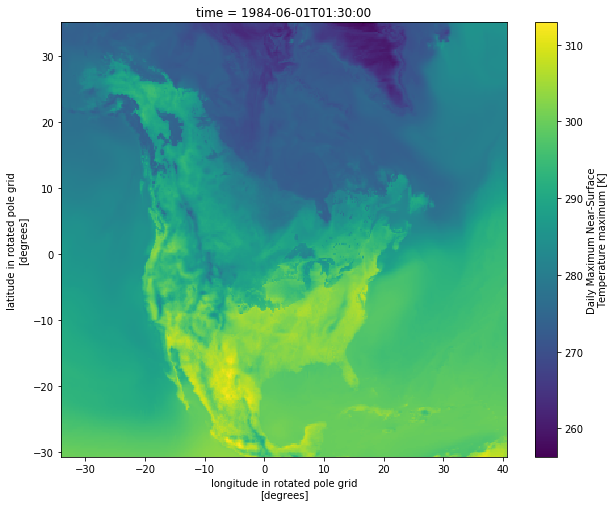

In [6]:
ds.tasmax.sel(time='1984-06-01').plot(figsize=(10,8), aspect='equal')

## On peut sélectionner plusieurs dimensions à la fois

Le méthode `sel` permet d'aller chercher les valeurs pour une coordonnée précise, une plage de coordonnées, ou même par plus proche voisin. Toutes ces sélections peuvent être mélangées dans n'importe quel ordre. 

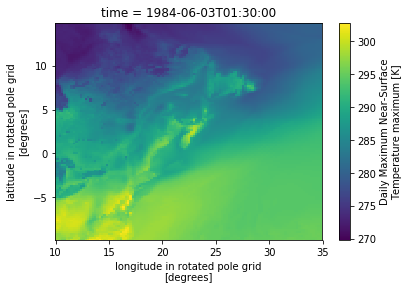

In [7]:
ds.tasmax.sel(time='1984-06-3', rlat=slice(-10, 15), rlon=slice(10, 35)).plot()

Ou aller chercher les valeurs de la coordonnées la plus proche:

In [8]:
ds.tasmax.sel(rlat=34, method='nearest', tolerance=1).isel(time=0)

<xarray.DataArray 'tasmax' (rlon: 340)>
array([272.957581, 273.117737, 273.249573, ..., 284.720856, 284.780426,
       284.821564])
Coordinates:
    lat      (rlon) float64 ...
    lon      (rlon) float64 ...
    rlat     float64 33.97
  * rlon     (rlon) float64 -33.99 -33.77 -33.55 -33.33 -33.11 -32.89 -32.67 ...
    time     datetime64[ns] 1984-06-01T01:30:00
Attributes:
    grid_mapping:   rotated_pole
    realm:          atmos
    level_desc:     Height
    long_name:      Daily Maximum Near-Surface Temperature maximum
    standard_name:  air_temperature maximum
    cell_methods:   time:  maximum
    cell_measures:  area: areacella
    units:          K
    poids:          poids

## Les opérations se font aussi selon les dimensions

Comme pour la sélection, les opérations sont effectuées le long de dimensions nommées explicitement. 

In [9]:
# Le max pour tous les pas de temps
ds.tasmax.max(dim='time')

<xarray.DataArray 'tasmax' (rlat: 300, rlon: 340)>
array([[301.025909, 301.059479, 301.047974, ..., 307.224274, 307.248688,
        306.126038],
       [301.046417, 301.079987, 301.029205, ..., 307.5065  , 307.522125,
        306.706696],
       [300.965912, 301.228424, 301.055756, ..., 307.594452, 307.458649,
        307.398102],
       ...,
       [279.092926, 279.514618, 276.846191, ..., 289.46524 , 289.652802,
        291.554169],
       [280.702301, 281.700165, 277.254852, ..., 290.751434, 290.984558,
        288.90741 ],
       [280.67984 , 281.816376, 276.171387, ..., 294.959167, 292.965027,
        288.410553]])
Coordinates:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
  * rlat     (rlat) float64 -30.71 -30.49 -30.27 -30.05 -29.83 -29.61 -29.39 ...
  * rlon     (rlon) float64 -33.99 -33.77 -33.55 -33.33 -33.11 -32.89 -32.67 ...

In [10]:
# Le max pour chaque pas de temps
ds.tasmax.max(dim=('rlon', 'rlat'))

<xarray.DataArray 'tasmax' (time: 30)>
array([312.918518, 312.885315, 311.706696, 311.838776, 311.707855, 312.20224 ,
       310.746277, 311.316406, 311.550812, 311.913422, 312.514862, 310.939362,
       311.257477, 312.712372, 313.827057, 313.322113, 312.716064, 311.752716,
       311.481903, 313.28833 , 314.84726 , 313.974792, 313.452118, 316.448151,
       315.868286, 315.170441, 313.556335, 315.070251, 316.596466, 317.674316])
Coordinates:
  * time     (time) datetime64[ns] 1984-06-01T01:30:00 1984-06-02T01:30:00 ...

## Les calendriers non-standards sont supportés

L'exemple plus haut utilise un calendrier `365_day`, automatiquement reconnu. 

## Le rééchantillonnage est trop facile 

On peut agréger une série à n'importe quelle échelle temporelle, peu importe que le calendrier soit standard ou pas. La méthode `resample` prend un paramètre de fréquence (`freq`) et retourne des groupes sur lesquels ont peut appliquer des opérateurs. 

In [11]:
g = ds.tasmax.resample(time='W')
g.groups

{numpy.datetime64('1984-06-03T00:00:00.000000000'): slice(0, 3, None),
 numpy.datetime64('1984-06-10T00:00:00.000000000'): slice(3, 10, None),
 numpy.datetime64('1984-06-17T00:00:00.000000000'): slice(10, 17, None),
 numpy.datetime64('1984-06-24T00:00:00.000000000'): slice(17, 24, None),
 numpy.datetime64('1984-07-01T00:00:00.000000000'): slice(24, None, None)}

In [12]:
g.mean()

<xarray.DataArray 'tasmax' (time: 5)>
array([287.111186, 287.687269, 288.851026, 289.483368, 290.419227])
Coordinates:
  * time     (time) datetime64[ns] 1984-06-03 1984-06-10 1984-06-17 ...

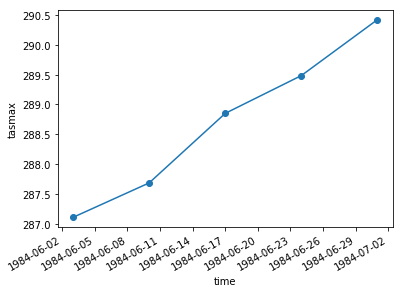

In [13]:
g.mean().plot(marker='o')